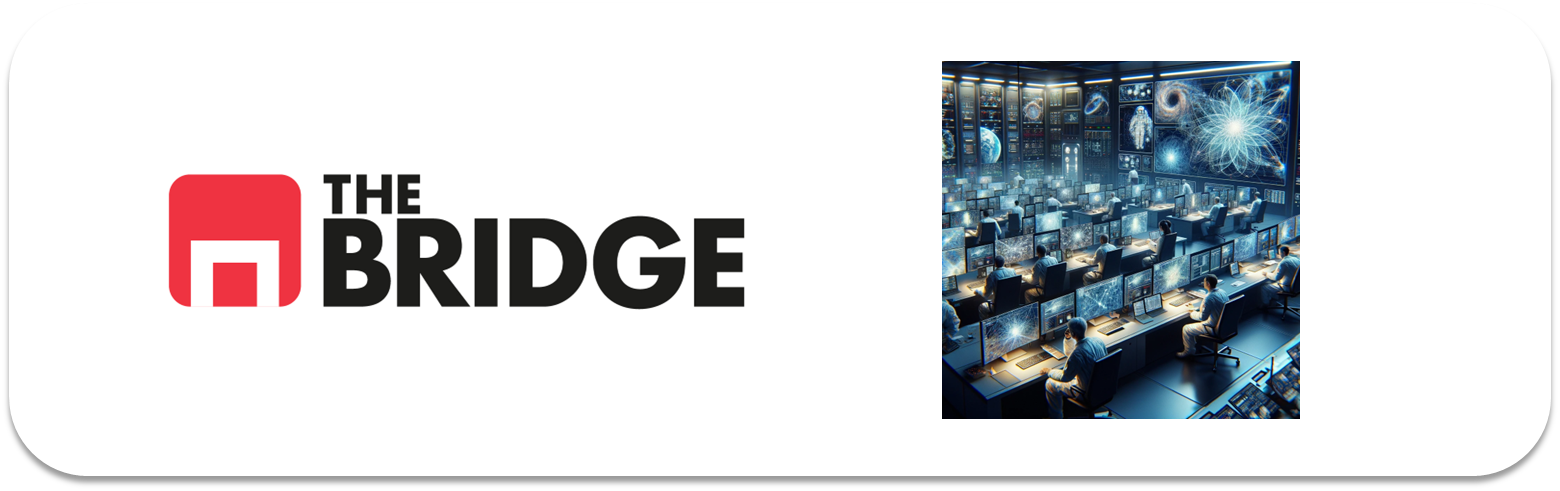

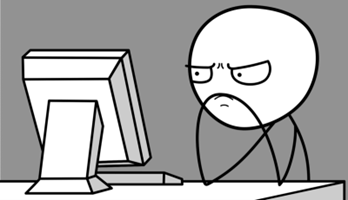

Para ejercitarte y afianzar lo aprendido sobre **Transfer Learning y Fine-tuning**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

## Apple 360

En este conjunto de ejercicios vas a montar un clasificador de manzanas mediante un dataset de imágenes. El dataset se compone de 13 tipos diferentes con aproximadamente unas 200 imágenes por cada tipo. Tendrás que montar un modelo de deep learning que utilice **transfer learning**. Se sugiere empezar con una red ResNet50 con imagenet.

El dataset original proviene del [concurso de Kaggle Fruits 360](https://www.kaggle.com/moltean/fruits), pero adaptado para la clasificación de una menor cantidad de casos (sólo las manzanas).


### Ejercicio 1

Crea los juegos de X,y para train y test a partir de los datos teninendo en cuenta su distribución, para ello tendrás que explorar las estructura. Crea un juego Train,test para resolución 32x32 y un juego de test adicional para 224x224. Es decir tendras que tener un X_train, X_test para 32x32 y un X_test adicional a 224x224

In [2]:
TRAIN_PATH = "./data/apples/Train"
TEST_PATH = "./data/apples/Test"

In [3]:
# Cargar datos train
X_train = []
y_train = []

for category in os.listdir(TRAIN_PATH):
    for file in os.listdir(os.path.join(TRAIN_PATH, category)):
        img = plt.imread(os.path.join(TRAIN_PATH, category, file))
        img = cv2.resize(img, (32, 32))
        X_train.append(img)
        y_train.append(category)

X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(6404, 32, 32, 3)
(6404,)


In [4]:
# Cargar datos test
X_test = []
y_test = []

for category in os.listdir(TEST_PATH):
    for file in os.listdir(os.path.join(TEST_PATH, category)):
        img = plt.imread(os.path.join(TEST_PATH, category, file))
        img = cv2.resize(img, (32, 32))
        X_test.append(img)
        y_test.append(category)

X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(2134, 32, 32, 3)
(2134,)


In [5]:
# Cargar datos test 224x224
X_test_224 = []
y_test_224 = []

for category in os.listdir(TEST_PATH):
    for file in os.listdir(os.path.join(TEST_PATH, category)):
        img = plt.imread(os.path.join(TEST_PATH, category, file))
        img = cv2.resize(img, (224, 224))
        X_test_224.append(img)
        y_test_224.append(category)

X_test_224 = np.array(X_test_224)
y_test_224 = np.array(y_test_224)

print(X_test_224.shape)
print(y_test_224.shape)

(2134, 224, 224, 3)
(2134,)


**NOTA:** A partir de aquí emplea siempre el X_train, X_test de 32x32 salvo en el ejercicio que se te diga lo contrario.

### Ejercicio 2

Haz una visualización de algunos de los datos. Crea una función que te ayude con ello.

In [6]:
def show_images_batch(images, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(images) - 1) // n_cols + 1)
    plt.figure(figsize = (n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, apple in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(apple)
        plt.axis("off")
        if len(names):
            plt.title(names[index])

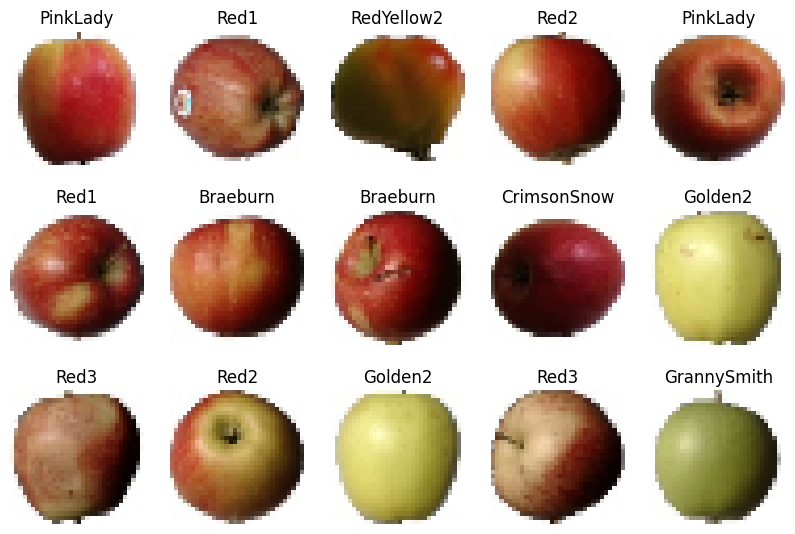

In [7]:
indices = np.random.randint(0, len(X_train), 15)
show_images_batch(X_train[indices], y_train[indices])

### Ejercicio 3

Completa el miniEDA habitual con imágenes y escoge una métrica para el modelo.

In [8]:
pd.Series(y_train).value_counts(normalize = True)

RedYellow2      0.104934
Braeburn        0.076827
Golden2         0.076827
GrannySmith     0.076827
Red1            0.076827
Red2            0.076827
RedYellow1      0.076827
RedDelicious    0.076515
Golden3         0.075109
Golden1         0.074953
PinkLady        0.071205
CrimsonSnow     0.069332
Red3            0.066989
Name: proportion, dtype: float64

### Ejercicio 4 

Termina de transformar los datos si crees que es conveniente y aunque el entrenamiento de modelos de keras ya tiene un shuffling interno, haz un "barajado" del X_train (del X_test no es necesario) para facilitar la convergencia inicial del modelo. Utiliza la función shuffle de sklearn y asigna la salida a un X_train distinto (es decir no machaques el inicial)

In [9]:
X_train = X_train / 255
X_test = X_test / 255

In [10]:
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train, random_state = 42)

### Ejercicio 5

Sklearn permite trabajar con etiquetas textuales pero keras no. Transforma las etiquetas a numéricas, creando dos diccionarios uno que permita traducir de etiqueta a clase numérica y otro que permita la transformación inversa.

In [11]:
# Mapeamos las categorías a números
categorias = np.unique(y_train)
n_categorias = len(categorias)

mapping = {cat: i for i, cat in enumerate(categorias)}
inverse_mapping = {valor:clave for clave,valor in mapping.items()}

In [12]:
# Mapeamos las etiquetas
y_train_num = np.array([mapping[cat] for cat in y_train_shuffle])
y_test_num = np.array([mapping[cat] for cat in y_test])

### Ejercicio 6: Zero Shot Learning

Descar el modelo ResNet50 preparado ya para poder usarlo directamente a la Zero Shot Learning. Pruébalo contra el test (aquí no valen nuestras categorías serán las que proporcione ResNet ojo). Prueba una selección aleatoria de imágenes del test y compara las etiquetas de ResNet con la que tiene. ¿Nos sirve este clasificador así tal cual?

In [13]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions

In [14]:
'''
imagenet es un corpus de imagenes con el que se ha clasificado el ResNet50V2
http://www.image-net.org/

Cargamos toda la red ya entrenada, y la usaremos para predecir
include_top=True --> Para que incluya la fully connected layer.
include_top=False --> Desarrollamos la fully connected layer
ojo el input shape que sea el de las imagenes que introduciremos. Esta limitado a imagenes de tamaño 224x224
classifier_activation se usa si include_top=True
'''

base_model = ResNet50V2(input_shape = (224, 224,3),
                        include_top = True, # Como vamos a emplearla directamente, incluimos también la parte de capas densas que hacen la predicción en este caso clasificación de imagenes 
                        weights = "imagenet", # Se carga con los pesos entrenados para el dataset de imagenet
                        classifier_activation = "softmax")

In [15]:
seleccion = np.random.randint(0, len(X_test_224), 20)
predictions = base_model.predict(X_test_224[seleccion])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


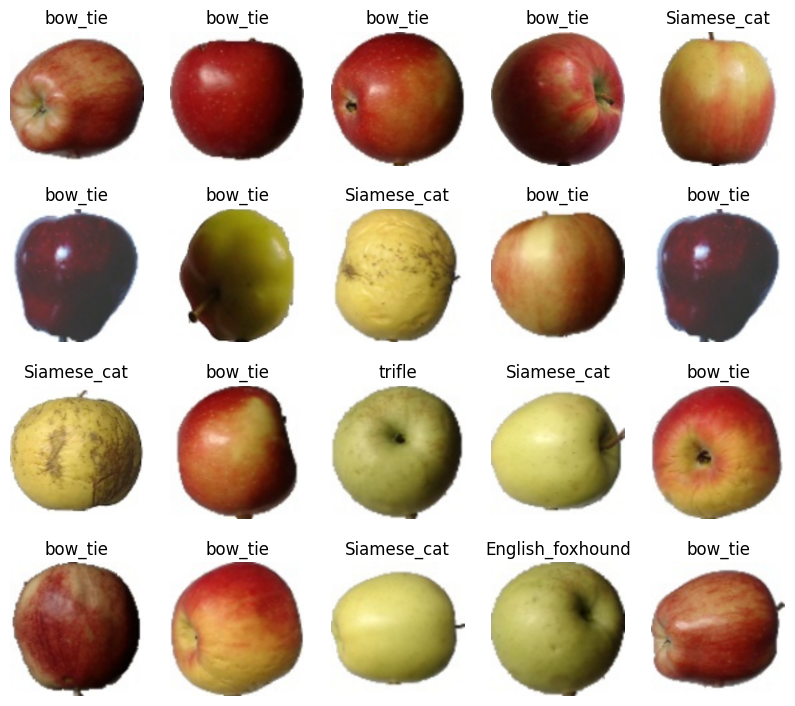

In [16]:
clase = [decodificado[0][1] for decodificado in decode_predictions(predictions)]
show_images_batch(X_test_224[seleccion], names = clase)

## Transfer Learning

### Ejercicio 7:

Carga la ResNet50 sin cabezas, crea un modelo con el anterior y una cabeza con dos capas densas, una oculta de 300 unidades (con activación "relu") y otra de salida con las unidades que crees necesarias y activación la que consideres. Congela las capas del modelo base (la ResNet50). Define también los hiperparámetros necesarios para compilar y compila el modelo y muestra un summary del mismo.

In [17]:
def prepare_model():

    base_model = ResNet50V2(input_shape = (32, 32, 3),
                        include_top = False, # Importante!!
                        weights = None, # Importante!!
                        classifier_activation = "softmax")

    for layer in base_model.layers:
        layer.trainable = False

    x = layers.Flatten()(base_model.output)
    x = layers.Dense(512, activation = "relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation = "sigmoid")(x)

    model = tf.keras.models.Model(base_model.input, x)

    model.compile(optimizer = "adam",
                  loss = "binary_crossentropy",
                  metrics = ["acc"])
    
    return model

model = prepare_model()

In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,614,401 (93.90 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### Ejercicio 8

Entrena el modelo con nuestros datos de train y muestra la evolución del entrenamiento. Emplea un callback de Earlystopping con patience a 5. Termina de escoger el batch_size y el número de épocas.

In [19]:
early_stopping = EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True)

In [20]:
history = model.fit(X_train_shuffle, 
                    y_train_num,
                    batch_size = 32,
                    validation_split = 0.2,
                    epochs = 20,
                   callbacks=[early_stopping])

Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - acc: 0.0704 - loss: -136.1102 - val_acc: 0.0695 - val_loss: -1259.8081
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - acc: 0.0703 - loss: -1999.3901 - val_acc: 0.0695 - val_loss: -5370.8696
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - acc: 0.0621 - loss: -6553.2583 - val_acc: 0.0695 - val_loss: -12352.9521
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - acc: 0.0713 - loss: -14250.1680 - val_acc: 0.0695 - val_loss: -22045.1953
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - acc: 0.0675 - loss: -24103.8516 - val_acc: 0.0695 - val_loss: -34178.6484
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - acc: 0.0712 - loss: -36109.7500 - val_acc: 0.0695 - val_loss: -48762.6211
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - acc: 0.0682 - loss: -50977.8320 - val_acc: 0.0695 - val_loss: -65509.9570
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - acc: 0.0674 - loss: -67808.2344 - val_ac

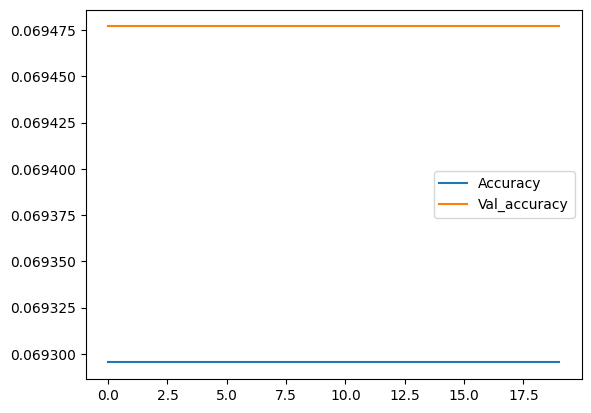

In [21]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df["acc"], label = "Accuracy")
plt.plot(history_df["val_acc"], label = "Val_accuracy")
plt.legend();

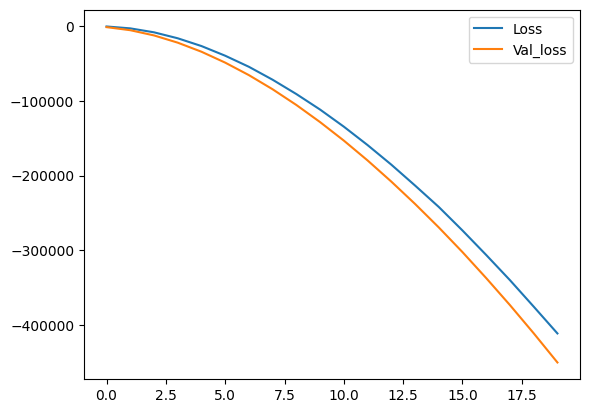

In [22]:
plt.plot(history_df["loss"], label = "Loss")
plt.plot(history_df["val_loss"], label = "Val_loss")
plt.legend();

### Ejercicio 9

Evalua el modelo contra test y haz un pequeño análisis de las diferencias. Haz un clasification report y muestra la matriz de confusion. Haz un pequeño análisis de errores.

In [23]:
model.evaluate(X_test, y_test_num)

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - acc: 0.1521 - loss: -170340.3125


[-437782.375, 0.06935332715511322]

In [24]:
y_pred = (model.predict(X_test))

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step


In [25]:
print(classification_report(y_test_num, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       164
           1       0.07      1.00      0.13       148
           2       0.00      0.00      0.00       160
           3       0.00      0.00      0.00       164
           4       0.00      0.00      0.00       161
           5       0.00      0.00      0.00       164
           6       0.00      0.00      0.00       152
           7       0.00      0.00      0.00       164
           8       0.00      0.00      0.00       164
           9       0.00      0.00      0.00       144
          10       0.00      0.00      0.00       166
          11       0.00      0.00      0.00       164
          12       0.00      0.00      0.00       219

    accuracy                           0.07      2134
   macro avg       0.01      0.08      0.01      2134
weighted avg       0.00      0.07      0.01      2134



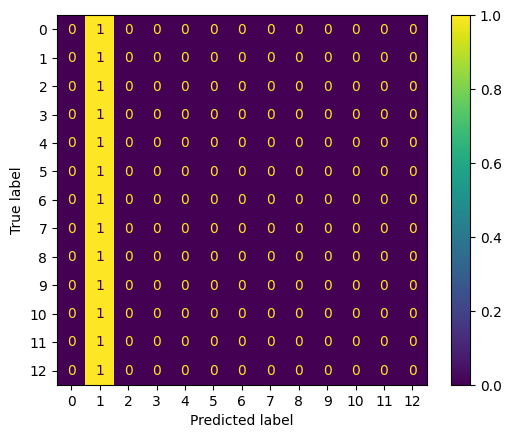

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test_num, y_pred, normalize = "true");

## Fine Tuning

### Ejercicio 10

Vuelve a descargar el modelo ResNet50 pero sin pesos entrenados, ni cabeza, crea el mismo modelo personalizado que en el ejercicio 7, compila y muestra el summary.

In [27]:
def prepare_model():

    base_model = ResNet50V2(input_shape = (32, 32, 3),
                        include_top = False, # Importante!!
                        weights = None, # Importante!!
                        classifier_activation = "softmax")

    for layer in base_model.layers:
        layer.trainable = False

    x = layers.Flatten()(base_model.output)
    x = layers.Dense(512, activation = "relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation = "sigmoid")(x)

    model = tf.keras.models.Model(base_model.input, x)

    model.compile(optimizer = "adam",
                  loss = "binary_crossentropy",
                  metrics = ["acc"])
    
    return model

model = prepare_model()

In [28]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,614,401 (93.90 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### Ejercicio 11
Entrena con batch_size a 64 y 60 épocas, con un EarlyStopping de patience a 10 (ahora el entrenamiento es sensiblemente más largo, así que tómate un descanso). Muestra la evolución y da una posible justificación a emplear tantas épocas de partida.

In [29]:
early_stopping = EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True)

In [30]:
history = model.fit(X_train_shuffle, 
                    y_train_num,
                    batch_size = 64,
                    validation_split = 0.2,
                    epochs = 60,
                   callbacks = [early_stopping])

Epoch 1/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - acc: 0.0683 - loss: -66.6562 - val_acc: 0.0695 - val_loss: -488.7564
Epoch 2/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - acc: 0.0721 - loss: -749.6338 - val_acc: 0.0695 - val_loss: -1987.4059
Epoch 3/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - acc: 0.0731 - loss: -2462.5498 - val_acc: 0.0695 - val_loss: -4601.3135
Epoch 4/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - acc: 0.0698 - loss: -5270.7876 - val_acc: 0.0695 - val_loss: -8319.7920
Epoch 5/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - acc: 0.0653 - loss: -9032.5332 - val_acc: 0.0695 - val_loss: -13148.9004
Epoch 6/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - acc: 0.0662 - loss: -13779.0273 - val_acc: 0.0695 - val_loss: -19047.3555
Epoch 7/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - acc: 0.0663 - loss: -20251.5410 - val_acc: 0.0695 - val_loss: -26040.7227
Epoch 8/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - acc: 0.0712 - loss: -26738.3535 - val_acc: 0.0695 - val_loss: -33954.

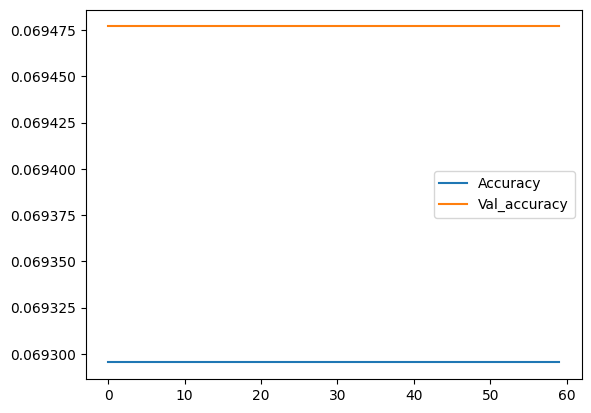

In [31]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df["acc"], label = "Accuracy")
plt.plot(history_df["val_acc"], label = "Val_accuracy")
plt.legend();

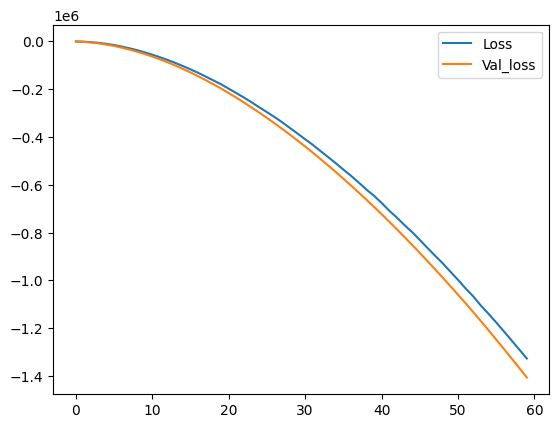

In [32]:
plt.plot(history_df["loss"], label = "Loss")
plt.plot(history_df["val_loss"], label = "Val_loss")
plt.legend();

### Ejercicio 12

Muestra la evaluación contra el test, el informe de clasificación  y la matriz de confusión. Compara los resultados con los del ejercicio 9.

In [33]:
model.evaluate(X_test, y_test_num)

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - acc: 0.1521 - loss: -531101.8125


[-1367960.5, 0.06935332715511322]

In [34]:
y_pred = (model.predict(X_test))

67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step


In [35]:
print(classification_report(y_test_num, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       164
           1       0.07      1.00      0.13       148
           2       0.00      0.00      0.00       160
           3       0.00      0.00      0.00       164
           4       0.00      0.00      0.00       161
           5       0.00      0.00      0.00       164
           6       0.00      0.00      0.00       152
           7       0.00      0.00      0.00       164
           8       0.00      0.00      0.00       164
           9       0.00      0.00      0.00       144
          10       0.00      0.00      0.00       166
          11       0.00      0.00      0.00       164
          12       0.00      0.00      0.00       219

    accuracy                           0.07      2134
   macro avg       0.01      0.08      0.01      2134
weighted avg       0.00      0.07      0.01      2134



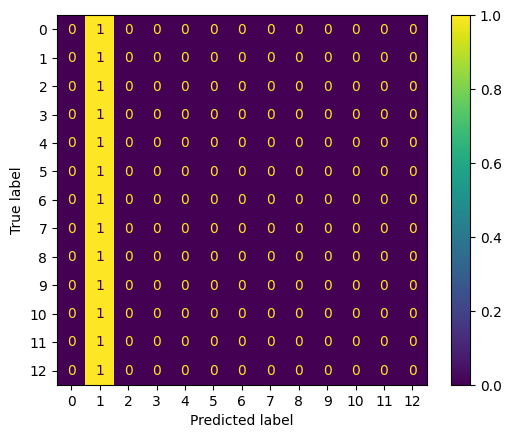

In [36]:
ConfusionMatrixDisplay.from_predictions(y_test_num, y_pred, normalize = "true");